# Date: 12th June 2019

In [1]:
import time
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
def partition_exp(n_particles=10, nevents=1, mu=1.):
    evals = np.random.exponential(scale = mu, size=(nevents,n_particles))
    sumRow =np.repeat(evals.sum(axis=1), n_particles).reshape(nevents, n_particles)
    evals = np.sort(np.divide(evals,sumRow))[:, ::-1]
    return evals

In [3]:
def makeJetImages(grid = 32, n_data = 10, n_particles = 5, isSignal = False, overlap=0):

    '''inputs: image size, number of datapoints, number of particles in each subjet, signal or background, amount of overlap'''
    '''outputs: array of images, radii, theta, labels, summed image'''

    # origin
    center = int((grid-1)/2)
    labels = np.zeros(n_data*2).reshape((n_data,2))
    print(labels.shape)
    
    # create input variables
    if isSignal:
        if (overlap==0):
            theta = np.random.normal(loc=0.2, scale=0.02, size=n_data) # signal_d
            z = np.random.normal(loc=0.5, scale=0.02, size=n_data) #signal_z 
        elif(overlap==1):
            theta = np.random.normal(loc=0.2, scale=0.03, size=n_data) # signal_d_littleoverlap
            z = np.random.normal(loc=0.5, scale=0.09, size=n_data) #signal_z_littleoverlap
        elif(overlap==2):
            theta = np.random.normal(loc=0.2, scale=0.05, size=n_data) # signal_d_overlap
            z = np.random.normal(loc=0.5, scale=0.12, size=n_data) #signal_z_overlap
        labels[:,1]=1
    else:
        if (overlap==0):
            theta = np.random.exponential(scale=0.02, size=n_data) # bkg_d
            z = np.random.exponential(scale=0.02, size=n_data) #bkg_z
        elif(overlap==1):
            theta = np.random.exponential(scale=0.03, size=n_data) # bkg_d_littleoverlap
            z = np.random.exponential(scale=0.1, size=n_data) #bkg_z_olittleverlap
        elif(overlap==2):
            theta = np.random.exponential(scale=0.05, size=n_data) # bkg_d_overlap
            z = np.random.exponential(scale=0.15, size=n_data) #bkg_z_overlap
        labels[:,0]=1
    
    # masking z to ensure z<1.0
    z = np.where(z<1.0, z, z%1) #signal_z   
    # making so that z is always more than 1-z
    z = np.where(z>0.5, z, (1-z))
    z = np.repeat(z, n_particles).reshape(n_data, n_particles)
    # masking theta to ensure theta<0.5
    theta = np.where(theta<0.5, theta, theta%0.5)
    theta = np.repeat(theta, n_particles).reshape(n_data, n_particles)
    
    # distributing pT fractions between particles
    particles1 = np.multiply(partition_exp(n_particles, n_data), z)
    particles2 = np.multiply(partition_exp(n_particles, n_data), (1-z))
    
    # one jet has two subjets 
    radii = np.random.uniform(0.25,0.5 ,size = (n_data,2))
    radii1 = np.array([np.multiply(np.ones(shape = (n_particles)),y) for y in radii[:,0]])
    radii2 = np.array([np.multiply(np.ones(shape = (n_particles)),y) for y in radii[:,1]])
    dtheta1 = np.random.exponential(scale=0.5, size=(n_data, n_particles)) # delta theta for first subjet
    dtheta1= np.sort(np.where(dtheta1<radii1, dtheta1, dtheta1%radii1))
    phi1 = np.random.uniform(0, 2*math.pi, size=(n_data, n_particles)) # angular
    dtheta2 = np.random.exponential(scale=0.5, size=(n_data, n_particles)) # delta theta for second subjet
    dtheta2= np.sort(np.where(dtheta2<radii2, dtheta2, dtheta2%radii2))
    phi2 = np.random.uniform(0, 2*math.pi, size=(n_data, n_particles)) # angular
    
    # position of particles on the grid : subscripts 1, 2 for particles in jet1, jet2 respectively   
    x1 = (np.multiply(dtheta1, np.cos(phi1))*grid).astype(int) + center
    x2 = (np.multiply(dtheta2, np.cos(phi2))*grid).astype(int) + center
    y1 = (np.multiply(dtheta1, np.sin(phi1))*grid).astype(int) + center
    y2 = ((np.multiply(dtheta2, np.sin(phi2))-theta)*grid).astype(int) + center

    ybins1 = np.arange(0,grid+1)
    xbins1 = np.arange(0,grid+1)
    
    # H1, H2 are the images from the first and second subjet respectively  
    H1_ = (np.vstack(np.array([(np.histogram2d( y1[i], x1[i], bins=(xbins1, ybins1), weights = particles1[i])) for i in range(n_data)])[:,0])).reshape(n_data, grid, grid)
    H2_ = (np.vstack(np.array([(np.histogram2d( y2[i], x2[i], bins=(xbins1, ybins1), weights = particles2[i])) for i in range(n_data)])[:,0])).reshape(n_data, grid, grid)
    H_ = (H1_+H2_) # images witb both subjets
    # performing a parity flip so that the right side of the jet image has the highest sum pixel intensity
    H_parity = np.sum(H_, axis=1)
    if (grid%2==0):
        H_left_ = np.repeat(np.sum(np.sum(H_, axis=1)[:,:center+1], axis=1), grid**2).reshape(n_data,grid,grid)
    else:
        H_left_ = np.repeat(np.sum(np.sum(H_, axis=1)[:,:center], axis=1), grid**2).reshape(n_data,grid,grid)
    H_right_ = np.repeat(np.sum(np.sum(H_, axis=1)[:,center+1:], axis=1), grid**2).reshape(n_data,grid,grid)
    images = np.where(H_right_>H_left_, H_, np.flip(H_, axis=2))
    avgImages = np.sum(images, axis =0)
    z = z.reshape(n_data*n_particles,1)[::n_particles]
    theta = theta.reshape(n_data*n_particles,1)[::n_particles]

    return images, radii, z, theta, labels, avgImages

In [4]:
grid = 16
n_data = 100000
n_particles = 10
overlap = 1

## 'Signal' jet images and their plots

In [5]:
tic = time.perf_counter()
isSignal1 = True
images1, radii1, z1, theta1, labels1, avgImages1 = makeJetImages(grid, n_data, n_particles, isSignal1, overlap)
toc = time.perf_counter()
print('Processing Time is ',toc-tic, 'seconds for ',n_data, ' samples.' )
np.savez('data/jetImages_signal_littleoverlap_train', jetImages = images1, radiilab = radii1, zlab = z1, thetalab = theta1, labels = labels1, sumedImage = avgImages1)

(100000, 2)
Processing Time is  34.48172237165272 seconds for  100000  samples.


In [6]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'white'}
# plt.rc('font', family='default')
# plt.rcParams['figure.dpi'] = 115
plt.rcParams.update(params)
plt.style.context('default')

#### Average signal image - log scale norm

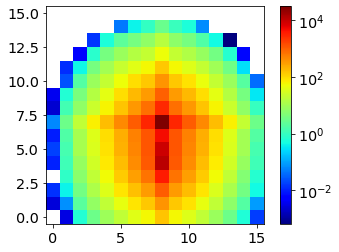

<Figure size 432x288 with 0 Axes>

In [7]:
# extent_sig = [-avgImages1.shape[1]/2., avgImages1.shape[1]/2., -avgImages1.shape[0]/2., avgImages1.shape[0]/2. ]
im1 = plt.imshow(avgImages1, interpolation='nearest', origin='low', norm=LogNorm(), cmap='jet')

plt.colorbar()
plt.show()
plt.savefig('signal_avgImage.png', bbox_inches='tight')

#### Individual 'signal' jet images

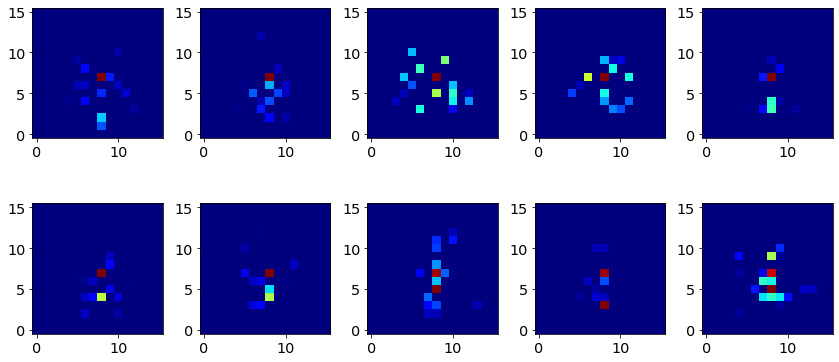

In [8]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(images1[i], interpolation='nearest', origin='low', cmap='jet')
plt.savefig('signal_eventImage.png', bbox_inches='tight')

## 'Background' jet images and their plots

In [9]:
tic = time.perf_counter()
isSignal2 = False
images2, radii2, z2, theta2, labels2, avgImages2 = makeJetImages(grid, n_data, n_particles, isSignal2, overlap)
toc = time.perf_counter()
print('Processing Time is ',toc-tic, 'seconds for ',n_data, ' samples.' )
np.savez('data/jetImages_bkg_littleoverlap_train', jetImages = images2, radiilab = radii2, zlab = z2, thetalab = theta2, labels = labels2, sumedImage = avgImages2)

(100000, 2)
Processing Time is  32.45884618163109 seconds for  100000  samples.


#### Average background image - log scale norm

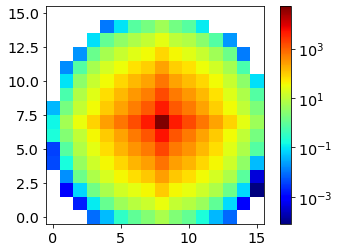

<Figure size 432x288 with 0 Axes>

In [10]:
im1 = plt.imshow(avgImages2, interpolation='nearest', origin='low', norm=LogNorm(), cmap='jet')
plt.colorbar()
plt.show()
plt.savefig('bkg_avgImage.png', bbox_inches='tight')

#### Individual 'background' jet images

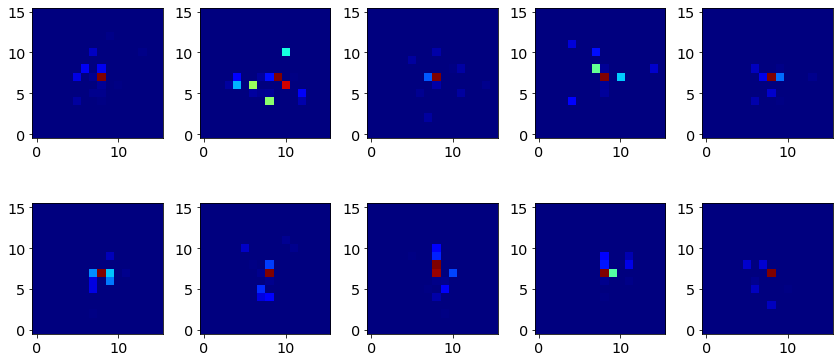

In [11]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(images2[i], interpolation='nearest', origin='low', cmap='jet')
plt.savefig('bkg_eventImage.png', bbox_inches='tight')

### Creating samples for Testing

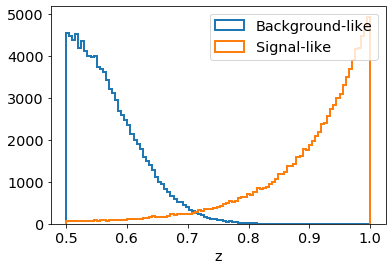

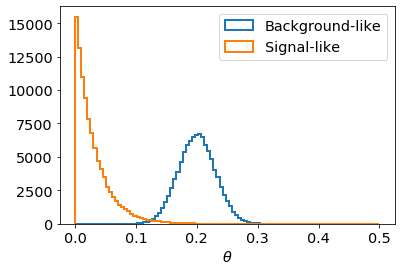

In [15]:
plt.hist(z1, bins=np.linspace(0.5,1,100), histtype='step', label='Background-like', lw=2)
plt.hist(z2, bins=np.linspace(0.5,1,100), histtype='step', label='Signal-like', lw=2)
plt.legend(loc = 'best')
plt.xlabel('z')
# plt.ylim(0,5000)
plt.savefig('z_plot.png', bbox_inches='tight')
plt.show()


plt.hist(theta1, bins=np.linspace(0,0.5,100), histtype='step', label='Background-like', lw=2)
plt.hist(theta2, bins=np.linspace(0,0.5,100), histtype='step', label='Signal-like', lw=2)
plt.legend(loc = 'best')
plt.xlabel(r'$\theta$')
# plt.ylim(0,11000)
plt.savefig('theta_plot.png', bbox_inches='tight')
plt.show()

In [13]:
n_data=20000

In [14]:
isSignal3 = True
images3, radii3, z3, theta3, labels3, avgImages3 = makeJetImages(grid, n_data, n_particles, isSignal3, overlap)
np.savez('data/jetImages_signal_littleoverlap_test', jetImages = images3, radiilab = radii3, zlab = z3, thetalab = theta3, labels = labels3, sumedImage = avgImages3)

isSignal4 = False
images4, radii4, z4, theta4, labels4, avgImages4 = makeJetImages(grid, n_data, n_particles, isSignal4, overlap)
np.savez('data/jetImages_bkg_littleoverlap_test', jetImages = images4, radiilab = radii4, zlab = z4, thetalab = theta4, labels = labels4, sumedImage = avgImages4)

(20000, 2)
(20000, 2)
